In [75]:
from statsforecast import StatsForecast
from statsforecast.models import (
    AutoARIMA,
    MSTL
)
import pandas as pd
import sys
sys.path.append('/Users/victor/code/Arizona3000/metro_seoul/metro_app/ml_logic')
from preprocess import preprocess_lstm, general_preprocessing, model_data_preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


# Imports

In [76]:
df = pd.read_csv('/Users/victor/code/Arizona3000/metro_seoul/raw_data/crowd2020-2023.csv')


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/1780909122.py:1: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



In [77]:
df = general_preprocessing(df)
df = model_data_preprocessing(df)


/Users/victor/code/Arizona3000/metro_seoul/metro_app/ml_logic/preprocess.py:62: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/victor/code/Arizona3000/metro_seoul/metro_app/ml_logic/preprocess.py:63: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [78]:
df.reset_index(inplace=True)


In [79]:
station_charlotte = [['Dongjak (Seoul National Cemetery)', 4],
 ['Gangnam', 2],
 ['Gireum', 4],
 ['Guro Digital Complex', 2],
 ['Gwanghwamun(Sejong Center for the Performing Arts)', 5],
 ['Hongik Univ.', 2],
 ['Itaewon', 6],
 ['Jamsilsaenae', 2],
 ['Mok-dong', 5],
 ['Nokbeon', 3],
 ['Seongsu', 2],
 ['Seoul Station', 1],
 ['Seoul Station', 4],
 ['World Cup Stadium(Seongsan)', 6],
 ['Yeonsinnae', 3],
 ['Yeonsinnae', 6],
 ['Yeouido', 5]]


In [80]:
df = df.groupby(['datetime', 'station_name', 'station_number', 'line'])['value'].sum().reset_index()


# StatsForecast

In [ ]:
models = [
    AutoARIMA(season_length=24),
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=24),
    HistoricAverage(),
    DOT(season_length=24)
]


In [58]:
df_station = df[(df['station_name'] == 'Gireum'.strip()) & (df['line'] == int(4))]

df_model = df_station[['station_name', 'datetime', 'value']]
df_model.rename(columns={'station_name':'unique_id', 'datetime':'ds', 'value':'y'}, inplace=True)


#split data test train
train_size = int(len(df_model) * 0.8)
train, test = df_model.iloc[:train_size, :], df_model.iloc[train_size:, :]

y_train = train[['y']]
X_train = train.drop(columns='y')

y_test = test[['y']]
X_test = test.drop(columns='y')

models = [MSTL(
    season_length=[24, 24 * 7, 24 * 7 * 2], # seasonalities of the time series  ##Ajouter 24*7*365,25
    trend_forecaster=AutoARIMA()
)]

sf = StatsForecast(
    models=models,
    df=train,
    freq='H',
    n_jobs=-1,
    )

forecast = sf.forecast(df = train, h = 24)


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3163793235.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [59]:
test


,unique_id,ds,y
6781677,Gireum,2022-10-18 15:00:00,2017
6781950,Gireum,2022-10-18 16:00:00,2614
6782223,Gireum,2022-10-18 17:00:00,3333
6782496,Gireum,2022-10-18 18:00:00,4850
6782769,Gireum,2022-10-18 19:00:00,3579
...,...,...,...
8450779,Gireum,2023-06-30 20:00:00,1906
8451052,Gireum,2023-06-30 21:00:00,1807
8451325,Gireum,2023-06-30 22:00:00,1745
8451598,Gireum,2023-06-30 23:00:00,1239


In [60]:
to_plot = forecast.merge(test, on='ds', how='left')


<Axes: xlabel='ds', ylabel='y'>

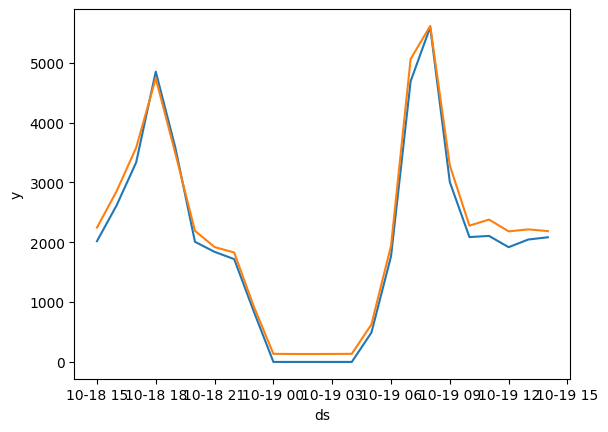

In [67]:
sns.lineplot(to_plot, x='ds', y='y')
sns.lineplot(to_plot, x='ds', y='MSTL')


In [48]:
# Instantiate StatsForecast class as sf
sf = StatsForecast(
    df=train,
    models=models,
    freq='H',
    n_jobs=-1,
)


In [49]:
forecasts_df = sf.forecast(h=24*7, level=[90])


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3997919026.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



61         Dongjak (Seoul National Cemetery)
336        Dongjak (Seoul National Cemetery)
611        Dongjak (Seoul National Cemetery)
886        Dongjak (Seoul National Cemetery)
1161       Dongjak (Seoul National Cemetery)
                         ...                
8450821    Dongjak (Seoul National Cemetery)
8451094    Dongjak (Seoul National Cemetery)
8451367    Dongjak (Seoul National Cemetery)
8451640    Dongjak (Seoul National Cemetery)
8451913    Dongjak (Seoul National Cemetery)
Name: station_name, Length: 30648, dtype: object
0.60360113781459


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3997919026.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



81         Gangnam
356        Gangnam
631        Gangnam
906        Gangnam
1181       Gangnam
            ...   
8450842    Gangnam
8451115    Gangnam
8451388    Gangnam
8451661    Gangnam
8451934    Gangnam
Name: station_name, Length: 30648, dtype: object
0.3047914097505983


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3997919026.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



90         Gireum
365        Gireum
640        Gireum
915        Gireum
1190       Gireum
            ...  
8450851    Gireum
8451124    Gireum
8451397    Gireum
8451670    Gireum
8451943    Gireum
Name: station_name, Length: 30648, dtype: object
0.2722608918561811


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3997919026.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



100        Guro Digital Complex
375        Guro Digital Complex
650        Guro Digital Complex
925        Guro Digital Complex
1200       Guro Digital Complex
                   ...         
8450860    Guro Digital Complex
8451133    Guro Digital Complex
8451406    Guro Digital Complex
8451679    Guro Digital Complex
8451952    Guro Digital Complex
Name: station_name, Length: 30648, dtype: object
0.283382112734755


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3997919026.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



104        Gwanghwamun(Sejong Center for the Performing A...
379        Gwanghwamun(Sejong Center for the Performing A...
654        Gwanghwamun(Sejong Center for the Performing A...
929        Gwanghwamun(Sejong Center for the Performing A...
1204       Gwanghwamun(Sejong Center for the Performing A...
                                 ...                        
8450864    Gwanghwamun(Sejong Center for the Performing A...
8451137    Gwanghwamun(Sejong Center for the Performing A...
8451410    Gwanghwamun(Sejong Center for the Performing A...
8451683    Gwanghwamun(Sejong Center for the Performing A...
8451956    Gwanghwamun(Sejong Center for the Performing A...
Name: station_name, Length: 30648, dtype: object
0.4066673939597891


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3997919026.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



118        Hongik Univ.
393        Hongik Univ.
668        Hongik Univ.
943        Hongik Univ.
1218       Hongik Univ.
               ...     
8450881    Hongik Univ.
8451154    Hongik Univ.
8451427    Hongik Univ.
8451700    Hongik Univ.
8451973    Hongik Univ.
Name: station_name, Length: 30648, dtype: object
0.2589516005421936


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3997919026.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



127        Itaewon
402        Itaewon
677        Itaewon
952        Itaewon
1227       Itaewon
            ...   
8450890    Itaewon
8451163    Itaewon
8451436    Itaewon
8451709    Itaewon
8451982    Itaewon
Name: station_name, Length: 30648, dtype: object
4.786334337139013


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3997919026.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



131        Jamsilsaenae
406        Jamsilsaenae
681        Jamsilsaenae
956        Jamsilsaenae
1231       Jamsilsaenae
               ...     
8450894    Jamsilsaenae
8451167    Jamsilsaenae
8451440    Jamsilsaenae
8451713    Jamsilsaenae
8451986    Jamsilsaenae
Name: station_name, Length: 30648, dtype: object
0.26754071796501777


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3997919026.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



164        Mok-dong
439        Mok-dong
714        Mok-dong
989        Mok-dong
1264       Mok-dong
             ...   
8450927    Mok-dong
8451200    Mok-dong
8451473    Mok-dong
8451746    Mok-dong
8452019    Mok-dong
Name: station_name, Length: 30648, dtype: object
0.274035052246875


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3997919026.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



181        Nokbeon
456        Nokbeon
731        Nokbeon
1006       Nokbeon
1281       Nokbeon
            ...   
8450945    Nokbeon
8451218    Nokbeon
8451491    Nokbeon
8451764    Nokbeon
8452037    Nokbeon
Name: station_name, Length: 30648, dtype: object
0.2914623353037968


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3997919026.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



214        Seongsu
489        Seongsu
764        Seongsu
1039       Seongsu
1314       Seongsu
            ...   
8450976    Seongsu
8451249    Seongsu
8451522    Seongsu
8451795    Seongsu
8452068    Seongsu
Name: station_name, Length: 30648, dtype: object
0.30261742230723326


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3997919026.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



218        Seoul Station
493        Seoul Station
768        Seoul Station
1043       Seoul Station
1318       Seoul Station
               ...      
8450980    Seoul Station
8451253    Seoul Station
8451526    Seoul Station
8451799    Seoul Station
8452072    Seoul Station
Name: station_name, Length: 30648, dtype: object
0.2652034868461753


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3997919026.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



219        Seoul Station
494        Seoul Station
769        Seoul Station
1044       Seoul Station
1319       Seoul Station
               ...      
8450981    Seoul Station
8451254    Seoul Station
8451527    Seoul Station
8451800    Seoul Station
8452073    Seoul Station
Name: station_name, Length: 30648, dtype: object
0.2541157584778858


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3997919026.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



258        World Cup Stadium(Seongsan)
533        World Cup Stadium(Seongsan)
808        World Cup Stadium(Seongsan)
1083       World Cup Stadium(Seongsan)
1358       World Cup Stadium(Seongsan)
                      ...             
8451019    World Cup Stadium(Seongsan)
8451292    World Cup Stadium(Seongsan)
8451565    World Cup Stadium(Seongsan)
8451838    World Cup Stadium(Seongsan)
8452111    World Cup Stadium(Seongsan)
Name: station_name, Length: 30648, dtype: object
1.0172488944594593


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3997919026.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



269        Yeonsinnae
544        Yeonsinnae
819        Yeonsinnae
1094       Yeonsinnae
1369       Yeonsinnae
              ...    
8451030    Yeonsinnae
8451303    Yeonsinnae
8451576    Yeonsinnae
8451849    Yeonsinnae
8452122    Yeonsinnae
Name: station_name, Length: 30648, dtype: object
0.2613620903897231


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3997919026.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



66415      Yeonsinnae
66692      Yeonsinnae
66969      Yeonsinnae
67246      Yeonsinnae
67523      Yeonsinnae
              ...    
8424894    Yeonsinnae
8425167    Yeonsinnae
8425440    Yeonsinnae
8425713    Yeonsinnae
8425986    Yeonsinnae
Name: station_name, Length: 4872, dtype: object
0.0


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3997919026.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



270        Yeouido
545        Yeouido
820        Yeouido
1095       Yeouido
1370       Yeouido
            ...   
8451031    Yeouido
8451304    Yeouido
8451577    Yeouido
8451850    Yeouido
8452123    Yeouido
Name: station_name, Length: 30648, dtype: object
0.33175722044389405


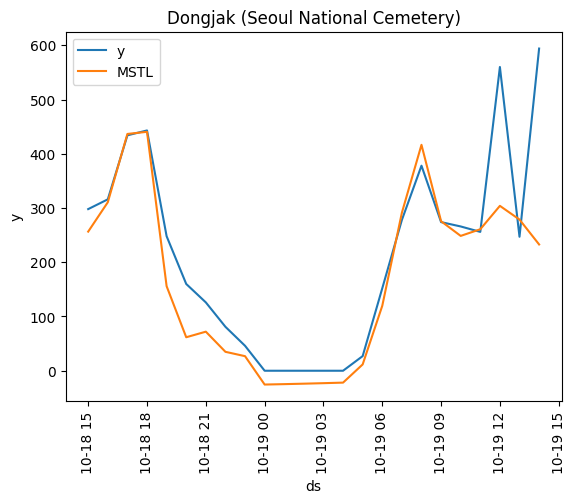

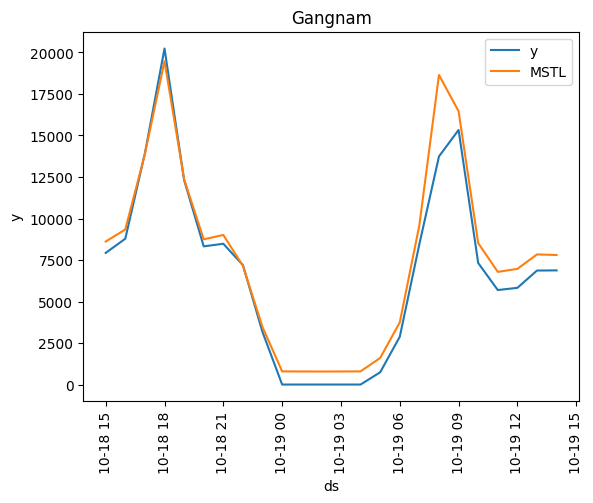

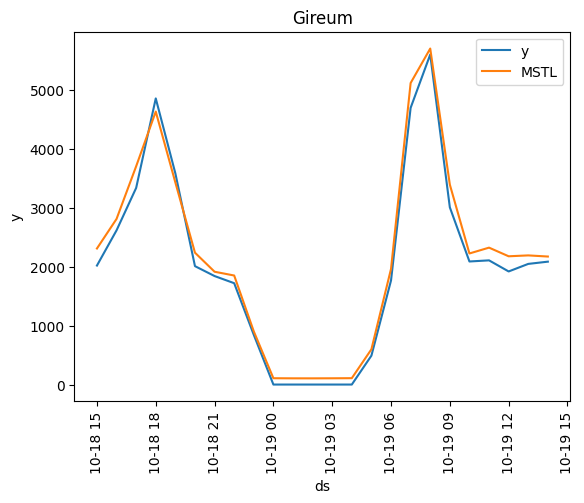

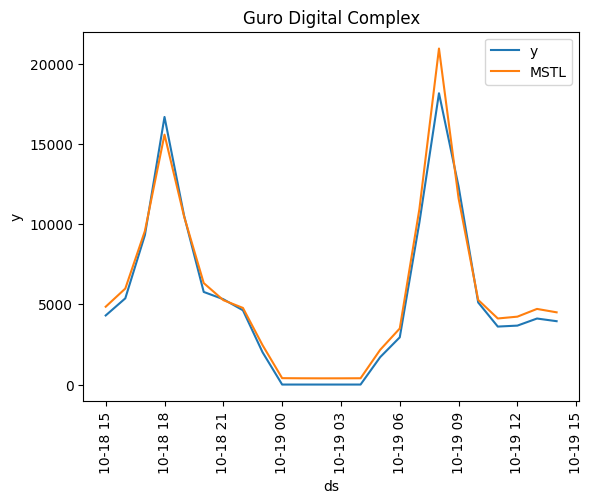

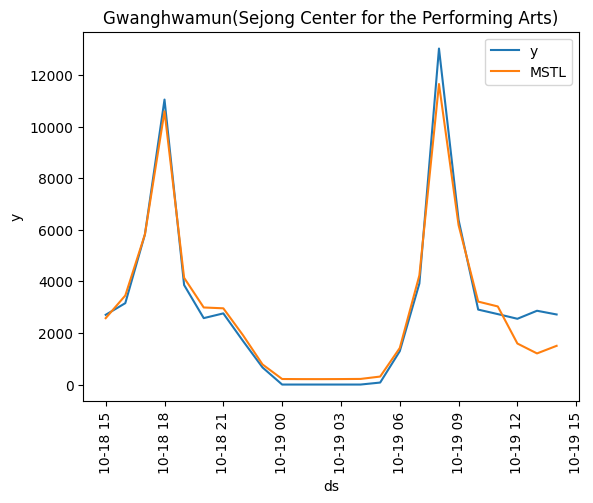

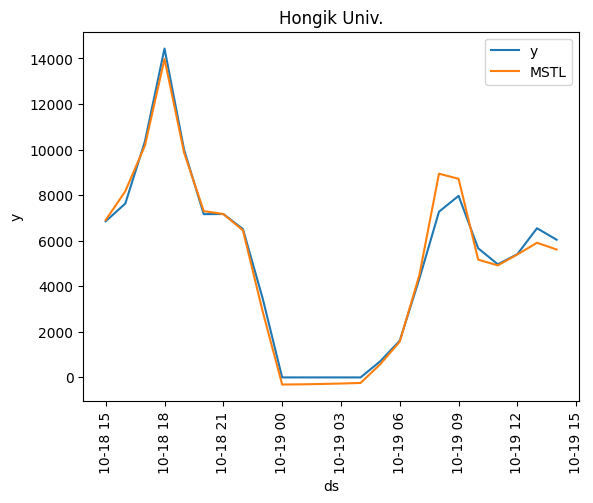

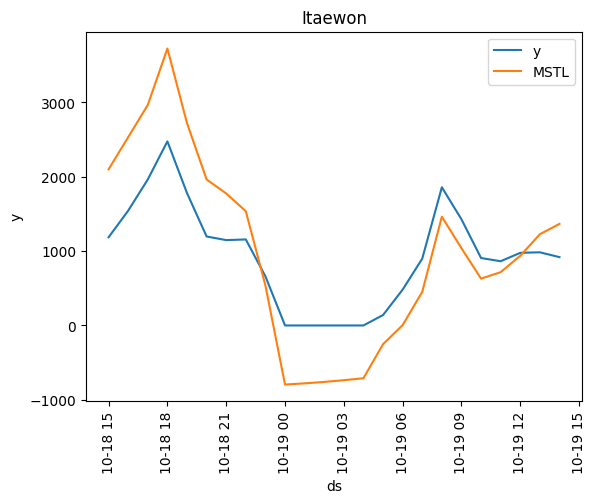

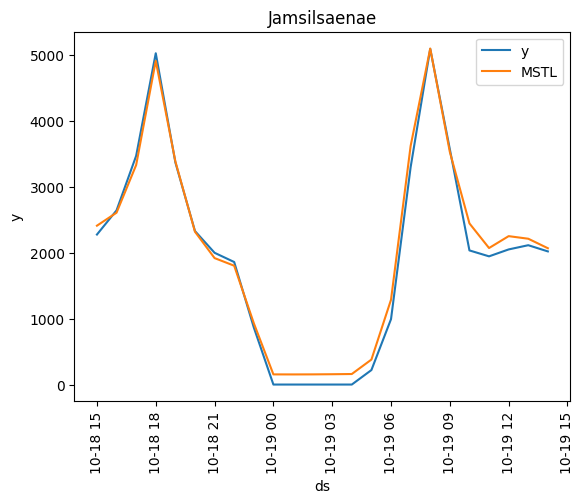

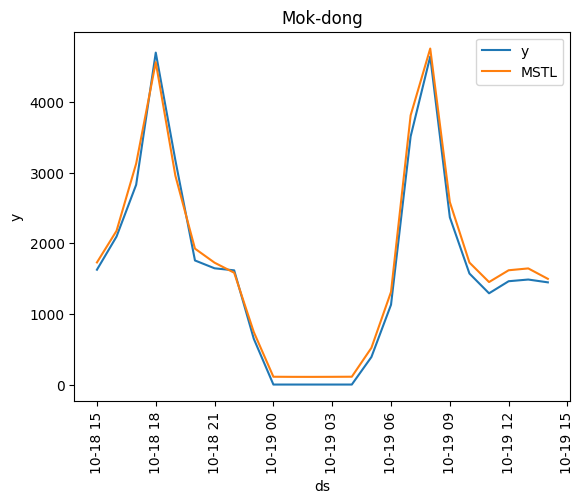

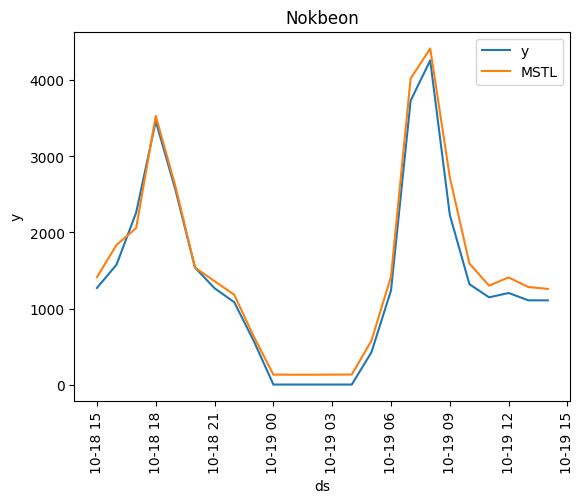

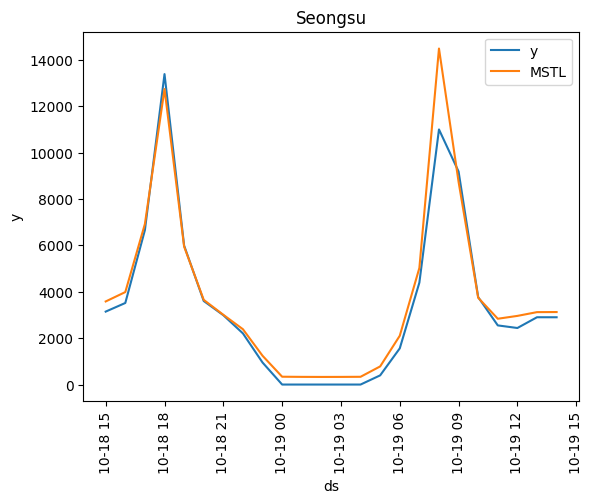

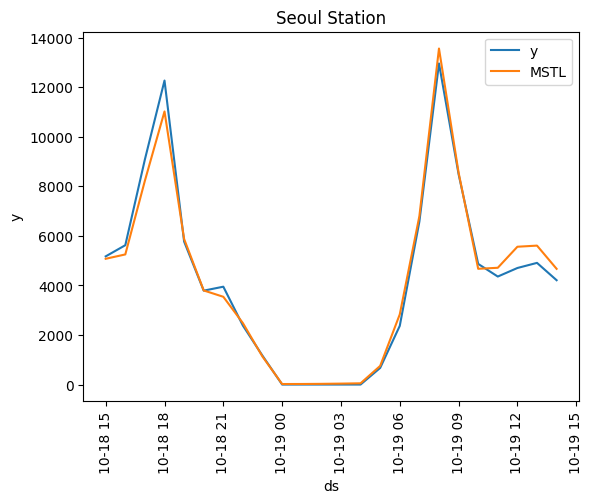

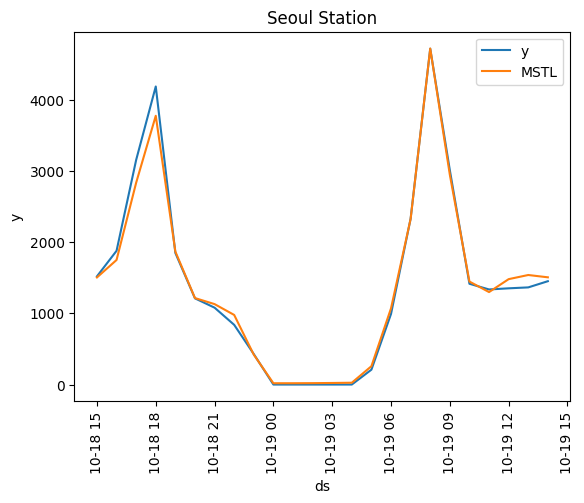

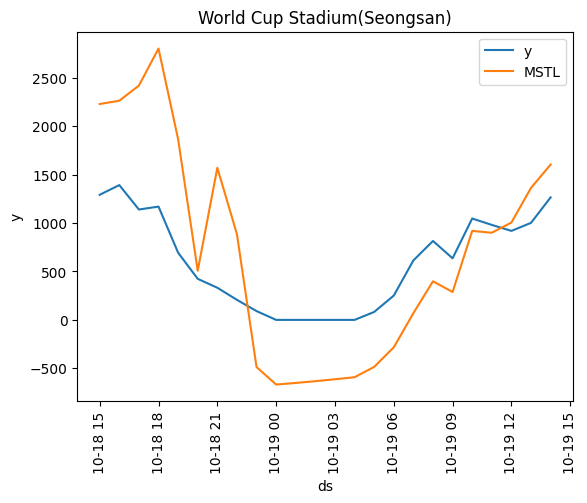

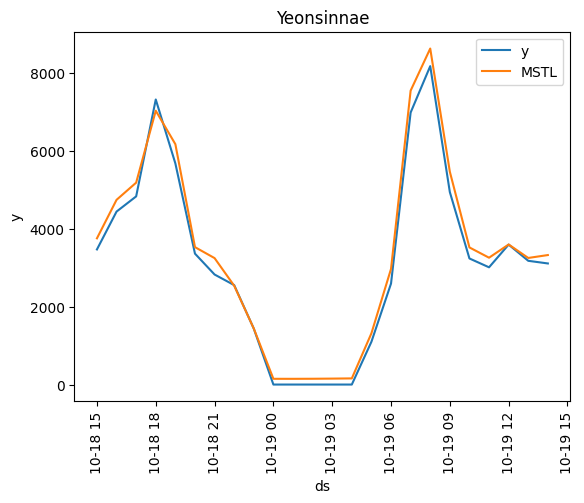

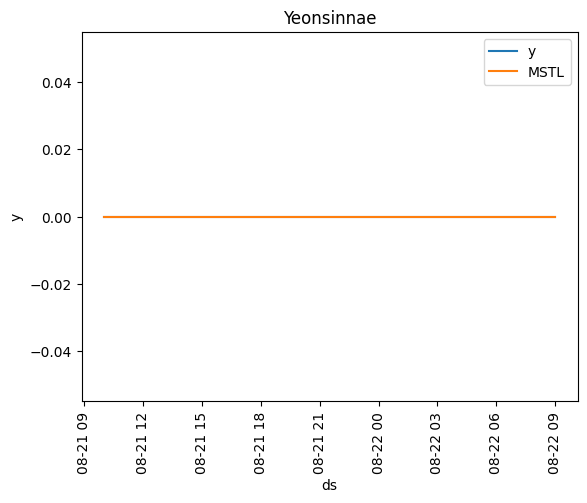

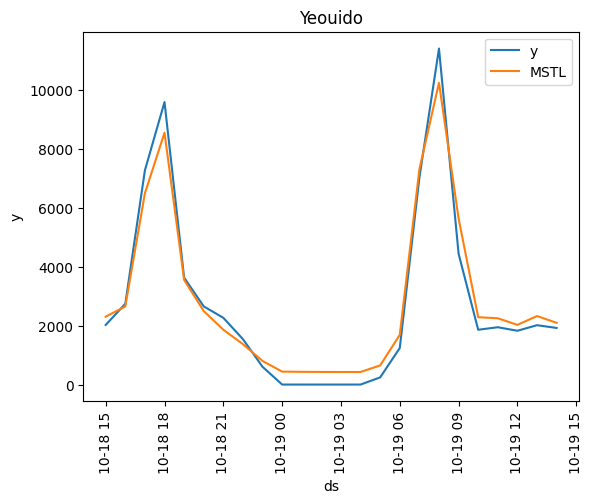

In [142]:
from sklearn.metrics import mean_absolute_percentage_error as mape

for station, station_line in station_charlotte:

    df_station = df[(df['station_name'] == station.strip()) & (df['line'] == int(station_line))]

    df_model = df_station[['station_name', 'datetime', 'value']]
    df_model.rename(columns={'station_name':'unique_id', 'datetime':'ds', 'value':'y'}, inplace=True)


    #split data test train
    train_size = int(len(df_model) * 0.8)
    train, test = df_model.iloc[:train_size, :], df_model.iloc[train_size:, :]

    y_train = train[['y']]
    X_train = train.drop(columns='y')

    y_test = test[['y']]
    X_test = test.drop(columns='y')

    models = [MSTL(
        season_length=[24, 24 * 7, 24 * 7 * 2, 24 * 7 * 52], # seasonalities of the time series  ##Ajouter 24*7*365,25
        trend_forecaster=AutoARIMA()
    )]

    sf = StatsForecast(
        models=models,
        df=train,
        freq='H',
        n_jobs=-1,
        )

    forecast = sf.forecast(df = train, h = 24)

    to_plot = forecast.merge(test, on='ds', how='left')

    fig, ax = plt.subplots()
    sns.lineplot(to_plot, x='ds', y='y', ax=ax, label='y')
    sns.lineplot(to_plot, x='ds', y='MSTL', ax=ax, label='MSTL')
    plt.title(station)
    plt.legend()
    plt.xticks(rotation=90)

    station_number = df_station.station_number.unique()[0]
    print(df_station.station_name)
    print(mape(forecast['MSTL'].values, test.head(24)['y'].values))
    #pickle.dump(sf, open(f'../models_test/MSTL{station_number}.pkl', 'wb'))


In [34]:
sf.predict(h=len(test), X_df=X_test)


/Users/victor/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/statsforecast/arima.py:1557: UserWarning: xreg not required by this model, ignoring the provided regressors
  warnings.warn(


,ds,MSTL
unique_id,,
Dongjak (Seoul National Cemetery),2022-10-18 15:00:00,266.970764
Dongjak (Seoul National Cemetery),2022-10-18 16:00:00,303.822510
Dongjak (Seoul National Cemetery),2022-10-18 17:00:00,406.805359
Dongjak (Seoul National Cemetery),2022-10-18 18:00:00,396.468018
Dongjak (Seoul National Cemetery),2022-10-18 19:00:00,138.827423
...,...,...
Dongjak (Seoul National Cemetery),2023-06-30 20:00:00,30.554430
Dongjak (Seoul National Cemetery),2023-06-30 21:00:00,81.502220
Dongjak (Seoul National Cemetery),2023-06-30 22:00:00,98.594795


In [35]:
y_test


,y
6781647,298
6781920,316
6782193,434
6782466,443
6782739,248
...,...
8450749,230
8451022,168
8451295,134
8451568,75


# Test model from file 

In [122]:
test_model = pickle.load(open('/Users/victor/code/Arizona3000/metro_seoul/models_test/MSTL150.pkl', 'rb'))


In [123]:
df_station = df[(df['station_name'] == 'Seoul Station'.strip()) & (df['line'] == int(1))]

df_model = df_station[['station_name', 'datetime', 'value']]
df_model.rename(columns={'station_name':'unique_id', 'datetime':'ds', 'value':'y'}, inplace=True)


#split data test train
train_size = int(len(df_model) * 0.8)
train, test = df_model.iloc[:train_size, :], df_model.iloc[train_size:, :]


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/796546844.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: >

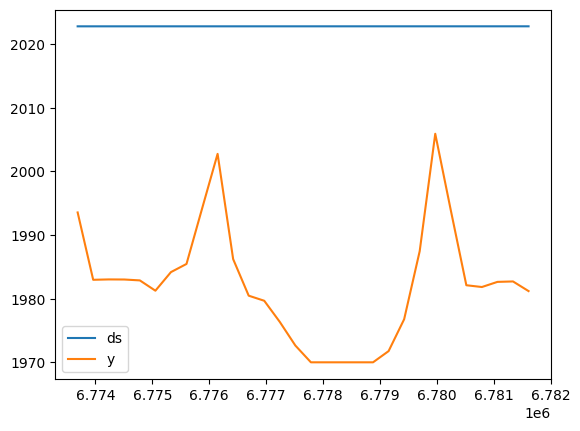

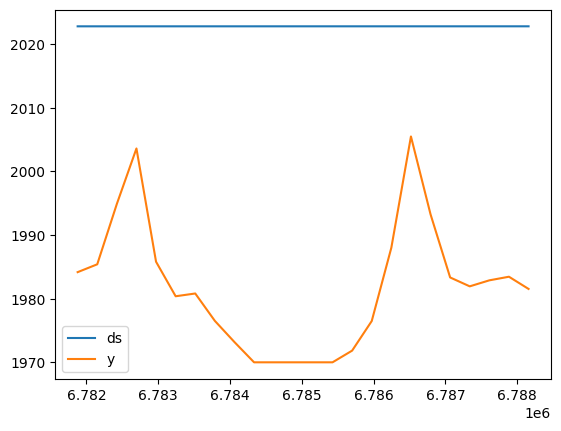

In [129]:
train.tail(30).plot()
test.head(24).plot()


In [127]:
test.head(24).plot()


,unique_id,ds,y
6781878,Seoul Station,2022-10-18 15:00:00,5175
6782151,Seoul Station,2022-10-18 16:00:00,5625
6782424,Seoul Station,2022-10-18 17:00:00,9090
6782697,Seoul Station,2022-10-18 18:00:00,12273
6782970,Seoul Station,2022-10-18 19:00:00,5773
6783243,Seoul Station,2022-10-18 20:00:00,3791
6783516,Seoul Station,2022-10-18 21:00:00,3950
6783789,Seoul Station,2022-10-18 22:00:00,2378
6784062,Seoul Station,2022-10-18 23:00:00,1162
6784335,Seoul Station,2022-10-19 00:00:00,0


In [130]:
forecast = test_model.forecast(df = train, h = 24)


In [133]:
test.head(24)['y']


6781878     5175
6782151     5625
6782424     9090
6782697    12273
6782970     5773
6783243     3791
6783516     3950
6783789     2378
6784062     1162
6784335        0
6784609        0
6784882        0
6785155        0
6785428        0
6785701      671
6785974     2369
6786247     6577
6786520    12962
6786793     8494
6787066     4870
6787339     4360
6787612     4705
6787885     4912
6788158     4212
Name: y, dtype: int64

In [137]:
from sklearn.metrics import mean_absolute_percentage_error as mape
mape(forecast['MSTL'].values, test.head(24)['y'].values)


0.2705555360572807

(array([19283.625, 19283.75 , 19283.875, 19284.   , 19284.125, 19284.25 ,
        19284.375, 19284.5  , 19284.625]),
 [Text(19283.625, 0, '10-18 15'),
  Text(19283.75, 0, '10-18 18'),
  Text(19283.875, 0, '10-18 21'),
  Text(19284.0, 0, '10-19 00'),
  Text(19284.125, 0, '10-19 03'),
  Text(19284.25, 0, '10-19 06'),
  Text(19284.375, 0, '10-19 09'),
  Text(19284.5, 0, '10-19 12'),
  Text(19284.625, 0, '10-19 15')])

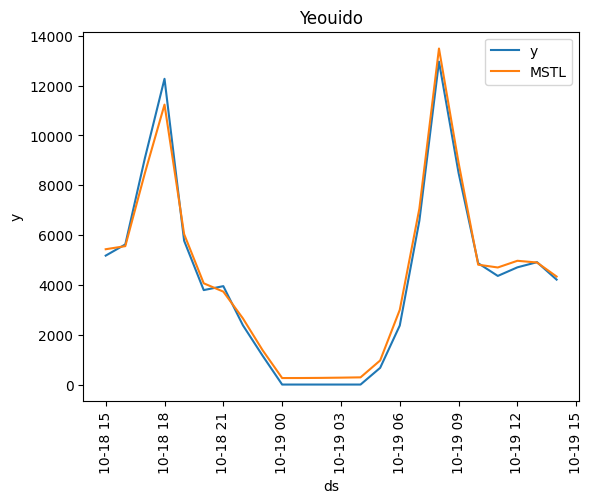

In [131]:
to_plot = forecast.merge(test, on='ds', how='left')

fig, ax = plt.subplots()
sns.lineplot(to_plot, x='ds', y='y', ax=ax, label='y')
sns.lineplot(to_plot, x='ds', y='MSTL', ax=ax, label='MSTL')
plt.title(station)
plt.legend()
plt.xticks(rotation=90)


In [94]:
df[df['station_number']=='150']


,datetime,station_name,station_number,line,value
6090601,2022-07-05 01:00:00,Seoul Station,150,1,0
6090874,2022-07-05 02:00:00,Seoul Station,150,1,0
6091147,2022-07-05 03:00:00,Seoul Station,150,1,0
6091420,2022-07-05 04:00:00,Seoul Station,150,1,0
6091693,2022-07-05 05:00:00,Seoul Station,150,1,619
...,...,...,...,...,...
6482159,2022-09-02 20:00:00,Seoul Station,150,1,4657
6482433,2022-09-02 21:00:00,Seoul Station,150,1,4551
6482707,2022-09-02 22:00:00,Seoul Station,150,1,3049
6482981,2022-09-02 23:00:00,Seoul Station,150,1,1688


In [139]:
from statsforecast.models import (
    AutoARIMA,
    AutoETS,
    AutoCES,
    AutoTheta,
)


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/701735355.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



AutoARIMA
0.2733915566365099


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/701735355.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



CES
0.5593444750454551


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/701735355.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Exception: Trend forecaster should not adjust seasonal models.

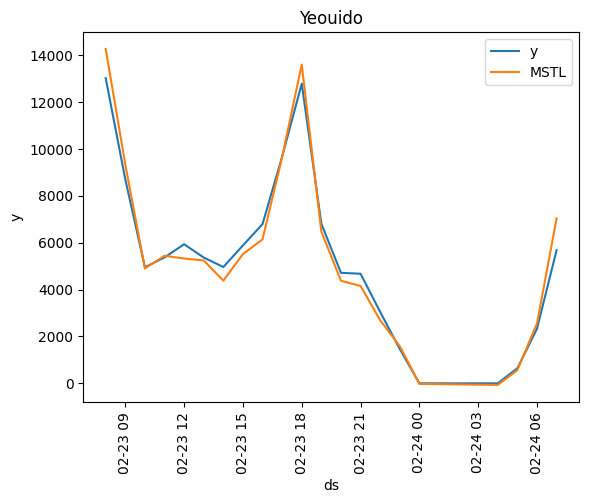

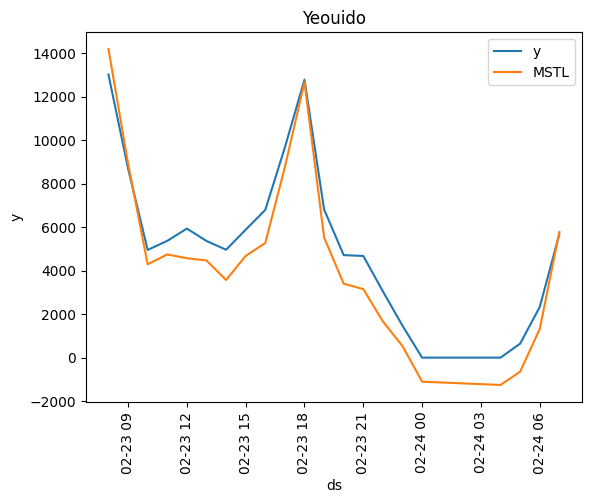

In [140]:
for model in [AutoARIMA(), AutoCES(), AutoETS(), AutoTheta()]:

    df_station = df[(df['station_name'] == 'Seoul Station'.strip()) & (df['line'] == int(1))]

    df_model = df_station[['station_name', 'datetime', 'value']]
    df_model.rename(columns={'station_name':'unique_id', 'datetime':'ds', 'value':'y'}, inplace=True)


    #split data test train
    train_size = int(len(df_model) * 0.9)
    train, test = df_model.iloc[:train_size, :], df_model.iloc[train_size:, :]


    y_test = test[['y']]
    X_test = test.drop(columns='y')

    models = [MSTL(
        season_length=[24, 24 * 7, 24 * 7 * 2], # seasonalities of the time series  ##Ajouter 24*7*365,25
        trend_forecaster=model
    )]

    sf = StatsForecast(
        models=models,
        df=train,
        freq='H',
        n_jobs=-1,
        )

    forecast = sf.forecast(df = train, h = 24)

    to_plot = forecast.merge(test, on='ds', how='left')

    fig, ax = plt.subplots()
    sns.lineplot(to_plot, x='ds', y='y', ax=ax, label='y')
    sns.lineplot(to_plot, x='ds', y='MSTL', ax=ax, label='MSTL')
    plt.title(station)
    plt.legend()
    plt.xticks(rotation=90)
    print(f'{model}')
    print(mape(forecast['MSTL'].values, test.head(24)['y'].values))


# Put all models done to google cloud 

In [117]:
sys.path.append('/Users/victor/code/Arizona3000/metro_seoul/gcp')
from setup import upload, cred
import os


In [121]:
for filename in os.listdir('/Users/victor/code/Arizona3000/metro_seoul/models_test'):

    print(upload(f'/Users/victor/code/Arizona3000/metro_seoul/models_test/{filename}', file_name=f'models/MSTL/{filename}', path_to_json_key='/Users/victor/gcp/metro-seoul-86af79318438.json'))


uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!


In [120]:
cred('/Users/victor/gcp/metro-seoul-86af79318438.json')


# Cross val model 